# 05 — Data Augmentation

Augmentasi data ABSA untuk mengatasi **class imbalance** dan **data scarcity**.

Distribusi aspek saat ini (sangat imbalanced):

| Sentiment | Kalimat | % |
|-----------|---------|---|
| POS | 2,036 | 83.1% |
| NEU | 625 | 25.5% |
| NEG | 433 | 17.7% |

Teknik augmentasi (ABSA-safe, preserve token-label alignment):
1. **Oversampling** — duplicate kalimat NEG (3x) dan NEU (2x)
2. **Random O-token deletion** — hapus 1-2 token O pada salinan
3. **Random O-token swap** — tukar posisi 2 token O bersebelahan
4. **Mention replacement** — ganti aspect term dengan aspect term lain (sentimen & panjang token sama)

In [6]:
import json
import os
import copy
import random
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

SEED = 42
random.seed(SEED)

### 1. LOAD DATA & ANALISIS DISTRIBUSI AWAL

In [7]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PROC_DIR = os.path.join(BASE_DIR, 'data', 'processed')

INPUT_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos.json')
OUTPUT_PATH = os.path.join(DATA_PROC_DIR, 'train_data_bieos_augmented.json')

with open(INPUT_PATH, 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f'Total samples: {len(data)}')
print(f'Sample format: {list(data[0].keys())}')
print(f'\nContoh:')
print(f'  tokens: {data[0]["tokens"][:8]}...')
print(f'  labels: {data[0]["labels"][:8]}...')

Total samples: 2451
Sample format: ['tokens', 'labels']

Contoh:
  tokens: ['banyak', 'hewan', 'blekok', 'nya']...
  labels: ['O', 'B-NEU', 'E-NEU', 'O']...


In [8]:
def get_sentiments(labels):
    """Extract unique sentiment types from BIEOS labels."""
    sentiments = set()
    for lab in labels:
        if lab != 'O':
            sentiments.add(lab.split('-', 1)[1])
    return sentiments

def categorize_samples(data):
    """Categorize samples by which sentiments they contain."""
    has_pos, has_neg, has_neu = [], [], []
    no_aspect = []
    for i, d in enumerate(data):
        sents = get_sentiments(d['labels'])
        if not sents:
            no_aspect.append(i)
            continue
        if 'POS' in sents:
            has_pos.append(i)
        if 'NEG' in sents:
            has_neg.append(i)
        if 'NEU' in sents:
            has_neu.append(i)
    return has_pos, has_neg, has_neu, no_aspect

has_pos, has_neg, has_neu, no_aspect = categorize_samples(data)

print('=== DISTRIBUSI AWAL ===')
print(f'Total samples     : {len(data)}')
print(f'Kalimat dengan POS: {len(has_pos)} ({len(has_pos)/len(data)*100:.1f}%)')
print(f'Kalimat dengan NEG: {len(has_neg)} ({len(has_neg)/len(data)*100:.1f}%)')
print(f'Kalimat dengan NEU: {len(has_neu)} ({len(has_neu)/len(data)*100:.1f}%)')
print(f'Tanpa aspek       : {len(no_aspect)} ({len(no_aspect)/len(data)*100:.1f}%)')

# Token-level distribution
label_counts = Counter()
for d in data:
    for lab in d['labels']:
        if lab != 'O':
            sentiment = lab.split('-', 1)[1]
            label_counts[sentiment] += 1

print(f'\nAspect tokens:')
for sent in ['POS', 'NEG', 'NEU']:
    print(f'  {sent}: {label_counts[sent]}')

=== DISTRIBUSI AWAL ===
Total samples     : 2451
Kalimat dengan POS: 2036 (83.1%)
Kalimat dengan NEG: 433 (17.7%)
Kalimat dengan NEU: 625 (25.5%)
Tanpa aspek       : 0 (0.0%)

Aspect tokens:
  POS: 5553
  NEG: 1099
  NEU: 1744


### 2. ASPECT TERM BANK

Kumpulkan semua aspect term dari dataset, kelompokkan berdasarkan **sentimen** dan **jumlah token**. Digunakan untuk mention replacement.

In [9]:
def extract_aspect_spans(tokens, labels):
    """Extract aspect spans as (start, end, sentiment, term_tokens)."""
    spans = []
    i = 0
    while i < len(labels):
        lab = labels[i]
        if lab.startswith('S-'):
            sentiment = lab.split('-', 1)[1]
            spans.append((i, i+1, sentiment, tuple([tokens[i]])))
            i += 1
        elif lab.startswith('B-'):
            sentiment = lab.split('-', 1)[1]
            start = i
            i += 1
            while i < len(labels) and (labels[i].startswith('I-') or labels[i].startswith('E-')):
                if labels[i].startswith('E-'):
                    i += 1
                    break
                i += 1
            spans.append((start, i, sentiment, tuple(tokens[start:i])))
        else:
            i += 1
    return spans

# Build aspect term bank: {sentiment: {token_count: [list of term tuples]}}
from collections import defaultdict
aspect_bank = defaultdict(lambda: defaultdict(list))

for d in data:
    spans = extract_aspect_spans(d['tokens'], d['labels'])
    for start, end, sentiment, term_tokens in spans:
        n_tokens = end - start
        if term_tokens not in aspect_bank[sentiment][n_tokens]:
            aspect_bank[sentiment][n_tokens].append(term_tokens)

print('=== ASPECT TERM BANK ===')
for sentiment in ['POS', 'NEG', 'NEU']:
    total = sum(len(v) for v in aspect_bank[sentiment].values())
    print(f'\n{sentiment} ({total} unique terms):')
    for n_tok in sorted(aspect_bank[sentiment].keys()):
        terms = aspect_bank[sentiment][n_tok]
        examples = [' '.join(t) for t in terms[:5]]
        print(f'  {n_tok}-token: {len(terms)} terms  (e.g. {", ".join(examples)}{"..." if len(terms) > 5 else ""})')

=== ASPECT TERM BANK ===

POS (1017 unique terms):
  1-token: 299 terms  (e.g. pemandangan, tempatnya, blekoknya, toilet, tempat...)
  2-token: 368 terms  (e.g. kampung blekok, wisata alam, hutan mangrove, burung air, wisata baru...)
  3-token: 185 terms  (e.g. destinasi wisata ini, wisata kampung blekok, tempat wisata alam, weekend sama keluarga, foto - foto...)
  4-token: 93 terms  (e.g. wisatawan dari berbagai daerah, lantunan merdu burung blekok, pemandangan gunung dan laut, jalan dermaga dan menara, tempat wisata kampung blekok...)
  5-token: 36 terms  (e.g. jalan menuju kawasan kampung blekok, penyuka wisata tradisi & sejarah, pesta kematian dan penguburan jenazah, objek wisata budaya dan purbakala, adat istiadat budaya suku toraja...)
  6-token: 20 terms  (e.g. harga makanan dan minuman , camilan, foto - foto pakai background alam, foto - foto depan rumah adat, foto - foto dengan rumah adat, ikon wisata di rantepao tana toraja...)
  7-token: 11 terms  (e.g. oleh - oleh / suvenir

### 3. FUNGSI AUGMENTASI

In [10]:
def random_o_deletion(sample, max_deletions=2):
    """Hapus 1-2 token berlabel O secara random.
    
    Hanya menghapus token O yang BUKAN di sebelah token aspek,
    supaya konteks aspek tetap terjaga.
    """
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    # Cari posisi O yang aman untuk dihapus (tidak bersebelahan dengan aspek)
    safe_o_indices = []
    for i, lab in enumerate(labels):
        if lab != 'O':
            continue
        left_ok = (i == 0) or (labels[i-1] == 'O')
        right_ok = (i == len(labels)-1) or (labels[i+1] == 'O')
        if left_ok and right_ok:
            safe_o_indices.append(i)
    
    if len(safe_o_indices) < 2:
        return None
    
    n_delete = min(random.randint(1, max_deletions), len(safe_o_indices))
    to_delete = set(random.sample(safe_o_indices, n_delete))
    
    new_tokens = [t for i, t in enumerate(tokens) if i not in to_delete]
    new_labels = [l for i, l in enumerate(labels) if i not in to_delete]
    
    if len(new_tokens) < 3:
        return None
    
    return {'tokens': new_tokens, 'labels': new_labels}


def random_o_swap(sample, max_swaps=2):
    """Tukar posisi 2 token O yang bersebelahan."""
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    swap_candidates = []
    for i in range(len(labels) - 1):
        if labels[i] == 'O' and labels[i+1] == 'O':
            if tokens[i] != tokens[i+1]:
                swap_candidates.append(i)
    
    if not swap_candidates:
        return None
    
    n_swaps = min(random.randint(1, max_swaps), len(swap_candidates))
    chosen = random.sample(swap_candidates, n_swaps)
    
    new_tokens = list(tokens)
    for i in chosen:
        new_tokens[i], new_tokens[i+1] = new_tokens[i+1], new_tokens[i]
    
    return {'tokens': new_tokens, 'labels': labels}


def mention_replacement(sample, aspect_bank):
    """Ganti aspect term dengan term lain yang sentimen & panjang token sama.
    
    Labels BIEOS tetap valid karena panjang span tidak berubah.
    """
    tokens = list(sample['tokens'])
    labels = list(sample['labels'])
    
    spans = extract_aspect_spans(tokens, labels)
    if not spans:
        return None
    
    # Pilih satu span secara random untuk di-replace
    span = random.choice(spans)
    start, end, sentiment, original_term = span
    n_tokens = end - start
    
    # Cari replacement dari bank
    candidates = aspect_bank.get(sentiment, {}).get(n_tokens, [])
    # Filter: jangan replace dengan term yang sama
    candidates = [c for c in candidates if c != original_term]
    
    if not candidates:
        return None
    
    replacement = random.choice(candidates)
    
    new_tokens = list(tokens)
    for i, new_tok in enumerate(replacement):
        new_tokens[start + i] = new_tok
    
    return {'tokens': new_tokens, 'labels': labels}


def augment_sample(sample, aspect_bank):
    """Terapkan salah satu augmentasi secara random.
    
    Distribusi: 30% O-deletion, 25% O-swap, 30% mention replacement, 15% exact copy
    """
    choice = random.random()
    if choice < 0.30:
        result = random_o_deletion(sample)
    elif choice < 0.55:
        result = random_o_swap(sample)
    elif choice < 0.85:
        result = mention_replacement(sample, aspect_bank)
    else:
        result = copy.deepcopy(sample)
    
    if result is None:
        result = copy.deepcopy(sample)
    
    return result

# Test semua teknik
test_sample = data[0]
print('Original:')
print(f'  tokens: {test_sample["tokens"]}')
print(f'  labels: {test_sample["labels"]}')

print('\n--- O-deletion ---')
r = random_o_deletion(test_sample)
if r: print(f'  tokens: {r["tokens"]}')
else: print('  (not applicable)')

print('\n--- O-swap ---')
r = random_o_swap(test_sample)
if r: print(f'  tokens: {r["tokens"]}')
else: print('  (not applicable)')

print('\n--- Mention replacement ---')
r = mention_replacement(test_sample, aspect_bank)
if r:
    print(f'  tokens: {r["tokens"]}')
    print(f'  labels: {r["labels"]}')
else:
    print('  (not applicable for this sample, trying another...)')
    for d in data[1:20]:
        r = mention_replacement(d, aspect_bank)
        if r:
            print(f'  original: {d["tokens"]}')
            print(f'  replaced: {r["tokens"]}')
            print(f'  labels  : {r["labels"]}')
            break

Original:
  tokens: ['banyak', 'hewan', 'blekok', 'nya']
  labels: ['O', 'B-NEU', 'E-NEU', 'O']

--- O-deletion ---
  (not applicable)

--- O-swap ---
  (not applicable)

--- Mention replacement ---
  tokens: ['banyak', 'burung', 'blekok', 'nya']
  labels: ['O', 'B-NEU', 'E-NEU', 'O']


### 4. AUGMENTASI

In [11]:
# Konfigurasi oversampling
NEG_MULTIPLIER = 3  # Duplicate kalimat NEG 3x (total jadi 4x termasuk original)
NEU_MULTIPLIER = 2  # Duplicate kalimat NEU 2x (total jadi 3x termasuk original)

# Start with all original data
augmented_data = copy.deepcopy(data)
n_original = len(augmented_data)

# Info kalimat mixed vs only
neg_only = [i for i in has_neg if i not in has_pos]
neg_and_pos = [i for i in has_neg if i in has_pos]
neu_only = [i for i in has_neu if i not in has_pos]
neu_and_pos = [i for i in has_neu if i in has_pos]

print(f'NEG-only sentences    : {len(neg_only)}')
print(f'NEG+POS sentences     : {len(neg_and_pos)}')
print(f'NEU-only sentences    : {len(neu_only)}')
print(f'NEU+POS sentences     : {len(neu_and_pos)}')

# Oversample NEG
n_neg_added = 0
for idx in has_neg:
    for _ in range(NEG_MULTIPLIER):
        aug = augment_sample(data[idx], aspect_bank)
        augmented_data.append(aug)
        n_neg_added += 1

# Oversample NEU
n_neu_added = 0
for idx in has_neu:
    for _ in range(NEU_MULTIPLIER):
        aug = augment_sample(data[idx], aspect_bank)
        augmented_data.append(aug)
        n_neu_added += 1

print(f'\nNEG augmented copies  : +{n_neg_added}')
print(f'NEU augmented copies  : +{n_neu_added}')
print(f'\nOriginal data         : {n_original}')
print(f'Augmented data        : {len(augmented_data)}')
print(f'Increase              : +{len(augmented_data) - n_original} ({(len(augmented_data)/n_original - 1)*100:.1f}%)')

NEG-only sentences    : 215
NEG+POS sentences     : 218
NEU-only sentences    : 239
NEU+POS sentences     : 386

NEG augmented copies  : +1299
NEU augmented copies  : +1250

Original data         : 2451
Augmented data        : 5000
Increase              : +2549 (104.0%)


### 5. ANALISIS HASIL AUGMENTASI

In [12]:
# Distribusi setelah augmentasi
has_pos_aug, has_neg_aug, has_neu_aug, no_aspect_aug = categorize_samples(augmented_data)

print('=== DISTRIBUSI SETELAH AUGMENTASI ===')
print(f'Total samples     : {len(augmented_data)}')
print(f'Kalimat dengan POS: {len(has_pos_aug)} ({len(has_pos_aug)/len(augmented_data)*100:.1f}%)')
print(f'Kalimat dengan NEG: {len(has_neg_aug)} ({len(has_neg_aug)/len(augmented_data)*100:.1f}%)')
print(f'Kalimat dengan NEU: {len(has_neu_aug)} ({len(has_neu_aug)/len(augmented_data)*100:.1f}%)')
print(f'Tanpa aspek       : {len(no_aspect_aug)}')

# Token-level distribution
label_counts_aug = Counter()
for d in augmented_data:
    for lab in d['labels']:
        if lab != 'O':
            sentiment = lab.split('-', 1)[1]
            label_counts_aug[sentiment] += 1

print(f'\nAspect tokens (before → after):')
for sent in ['POS', 'NEG', 'NEU']:
    before = label_counts[sent]
    after = label_counts_aug[sent]
    print(f'  {sent}: {before:,} → {after:,} (+{after-before:,}, {after/before:.1f}x)')

=== DISTRIBUSI SETELAH AUGMENTASI ===
Total samples     : 5000
Kalimat dengan POS: 3462 (69.2%)
Kalimat dengan NEG: 1918 (38.4%)
Kalimat dengan NEU: 2154 (43.1%)
Tanpa aspek       : 0

Aspect tokens (before → after):
  POS: 5,553 → 9,685 (+4,132, 1.7x)
  NEG: 1,099 → 4,880 (+3,781, 4.4x)
  NEU: 1,744 → 6,066 (+4,322, 3.5x)


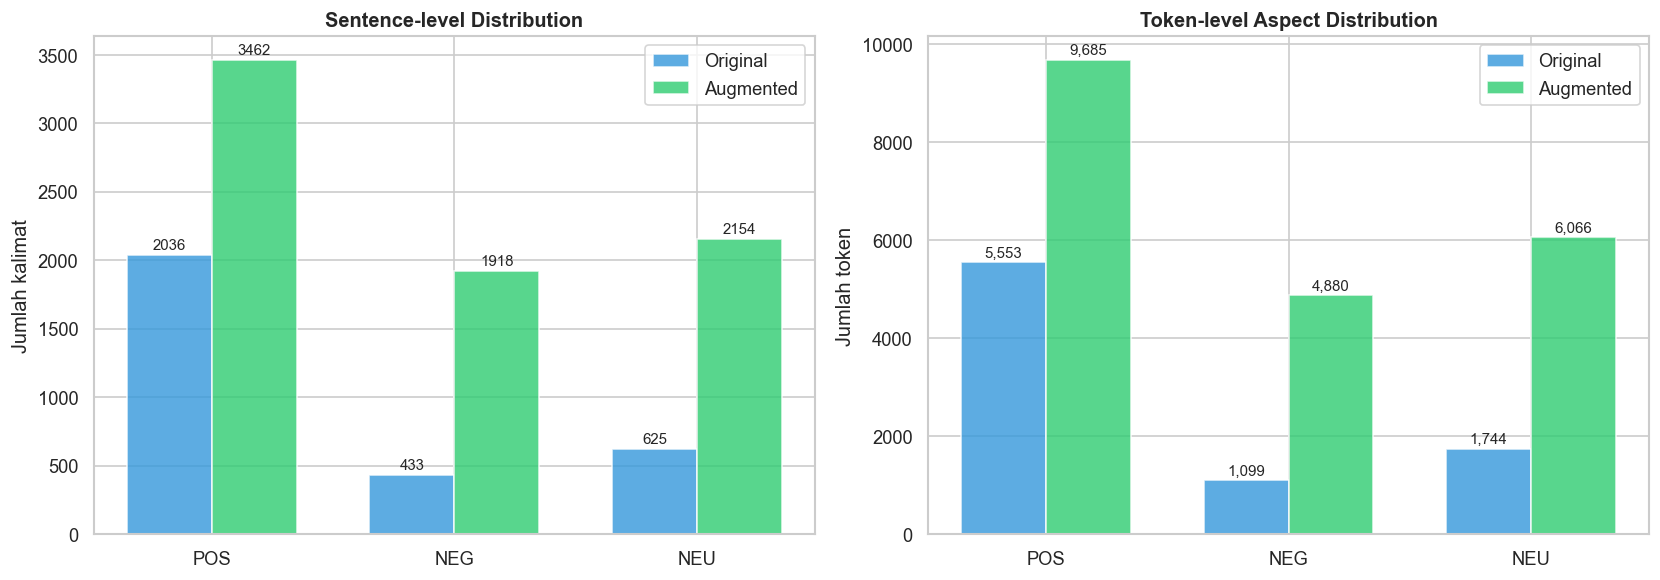

In [13]:
# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentence-level
categories = ['POS', 'NEG', 'NEU']
before_counts = [len(has_pos), len(has_neg), len(has_neu)]
after_counts = [len(has_pos_aug), len(has_neg_aug), len(has_neu_aug)]

x = range(len(categories))
width = 0.35
bars1 = axes[0].bar([i - width/2 for i in x], before_counts, width, label='Original', color='#3498db', alpha=0.8)
bars2 = axes[0].bar([i + width/2 for i in x], after_counts, width, label='Augmented', color='#2ecc71', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].set_title('Sentence-level Distribution', fontweight='bold')
axes[0].set_ylabel('Jumlah kalimat')
axes[0].legend()

# Tambah angka di atas bar
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 20,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)

# Token-level
before_tokens = [label_counts[s] for s in categories]
after_tokens = [label_counts_aug[s] for s in categories]

bars3 = axes[1].bar([i - width/2 for i in x], before_tokens, width, label='Original', color='#3498db', alpha=0.8)
bars4 = axes[1].bar([i + width/2 for i in x], after_tokens, width, label='Augmented', color='#2ecc71', alpha=0.8)
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories)
axes[1].set_title('Token-level Aspect Distribution', fontweight='bold')
axes[1].set_ylabel('Jumlah token')
axes[1].legend()

for bar in bars3:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 50,
                 f'{int(bar.get_height()):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
# Validasi: cek semua sample punya format yang benar
errors = 0
for i, d in enumerate(augmented_data):
    if len(d['tokens']) != len(d['labels']):
        print(f'ERROR sample {i}: tokens({len(d["tokens"])}) != labels({len(d["labels"])})')
        errors += 1
    if len(d['tokens']) < 2:
        print(f'ERROR sample {i}: too short ({len(d["tokens"])} tokens)')
        errors += 1
    # Cek label valid
    valid_labels = {'O', 'B-POS', 'B-NEG', 'B-NEU', 'I-POS', 'I-NEG', 'I-NEU',
                    'E-POS', 'E-NEG', 'E-NEU', 'S-POS', 'S-NEG', 'S-NEU'}
    for lab in d['labels']:
        if lab not in valid_labels:
            print(f'ERROR sample {i}: invalid label "{lab}"')
            errors += 1

if errors == 0:
    print(f'Validasi OK — semua {len(augmented_data)} samples valid')
else:
    print(f'\nDitemukan {errors} error!')

Validasi OK — semua 5000 samples valid


### 6. SIMPAN DATA AUGMENTED

In [15]:
# Shuffle data augmented
random.shuffle(augmented_data)

with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
    json.dump(augmented_data, f, ensure_ascii=False, indent=2)

file_size = os.path.getsize(OUTPUT_PATH) / (1024**2)
print(f'Saved: {OUTPUT_PATH}')
print(f'File size: {file_size:.1f} MB')
print(f'Total samples: {len(augmented_data)}')
print(f'\nSummary:')
print(f'  Original   : {n_original} samples')
print(f'  Augmented  : {len(augmented_data)} samples (+{len(augmented_data)-n_original})')
print(f'  NEG copies : +{n_neg_added} (x{NEG_MULTIPLIER})')
print(f'  NEU copies : +{n_neu_added} (x{NEU_MULTIPLIER})')

Saved: d:\Kuliah\TA\Notebook\data\processed\train_data_bieos_augmented.json
File size: 3.9 MB
Total samples: 5000

Summary:
  Original   : 2451 samples
  Augmented  : 5000 samples (+2549)
  NEG copies : +1299 (x3)
  NEU copies : +1250 (x2)
